# Working with Imagery

In this notebook we'll learn how satellite imagery is stored, retrieve some, and do something with it.


## How Imagery Works

DigitalGlobe owns and operates bus-sized satellites that orbit the Earth. These satellites are taking photos all the time and don't just point down, they also can look around at different angles. They take photos not just in visible light but other bands, like infra-red which is useful in certain agricultural use-cases.

Here's what one of these satellites looks like, WorldView-4:

![WorldView-4](https://stevecoast.com/dg/notebook/sat.png)

The satellite is tasked many times a day to take pictures which are called strips and look like this:

![Satellite image strip](https://stevecoast.com/dg/notebook/strip.png)

Each strip is many miles longer than wide, and is around 30Gb of data per strip. The small white things you see at the bottom of the strip are clouds - strips can cover very large areas of the Earth.

Each image is shot at a certain time and date, at a certain angle and contains some amount of clouds which obscure the ground. DigitalGlobe's archive stretches back many years and is many Petabyes in size. This vast amount of data is stored on tapes (in what we call a 'factory'), managed by robots like this:

![Tape Storage Robot](https://stevecoast.com/dg/notebook/robot.png)

To get an image, we need to:

1. Find an area of Earth we're interested in.
2. Find out what image strips exist for that area.
3. Pull in the image strips to the GBDX platform from factory tape storage.
4. Load the image in to the notebook.
5. Do something with the image.

Let's start!

## 1. Find an Area of Interest

An area of interest, or aoi, can be a simple bounding box, or bbox. Let's start with a small area in Colorado defined by longitudes and latitudes: 

In [6]:
bbox = [-107.016792,38.852676,-106.894398,38.929903]

## 2. Find Image Strips

Here, we'll find the image strips that contain our area of interest.

We need to import a number of support functions for use with the data we're looking for:

In [7]:
import time
import json
from shapely.geometry import box
from gbdxtools import Interface
gbdx = Interface()

To search for image strips, we'll define a helper function that uses the GBDX APIs to find an image. It uses the bounding box and a type of satellite (DigitalGlobe operates multiple satellites). By default, it'll return 100 results with cloud covering less than 10% of the image. The function builds some SQL-like statements and passes them to the API:

In [8]:
def search_unordered(bbox, _type, count=100, cloud_cover=10):
    aoi = box(*bbox).wkt
    query = "item_type:{} AND item_type:DigitalGlobeAcquisition".format(_type)
    query += " AND attributes.cloudCover_int:<{}".format(cloud_cover)
    return gbdx.vectors.query(aoi, query, count=count)

Now let's find some records using the WorldView-2 satellite. We use the helper function we just defined to search using the bbox we defined. From the records returned, we can find the catalogue ID, and as an example, print the 4th ID we have. Each ID refers to an image strip, described at the top of this notebook:

In [12]:
records = search_unordered(bbox, 'WV02')
ids = [r['properties']['attributes']['catalogID'] for r in records]
print(ids[3])

103001004965BE00


## 3. Pull the Image Strips in to the GBDX Platform

Now we need to order the strips from the factory and pull them in to the GBDX platform. To do this, we'll define another helper function which calls the GBDX APIs to set up a ordering task, attach it to a workflow and then execute the workflow: 

In [13]:
def order(img_id):
    order = gbdx.Task("Auto_Ordering", cat_id=img_id)
    order.impersonation_allowed = True
    wf = gbdx.Workflow([order])
    wf.execute()
    return wf

Now let's order all the strips that we have IDs for:

In [14]:
wfs = [order(w) for w in ids]

We can query these running workflows to see what their status is by running the following snippet. Run this snippet of code and watch as the imagery is pulled in. Each workflow will change from pending, to running, to complete:

In [16]:
for w in wfs:
    print w.status

{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}


{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}


{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}
{u'state': u'complete', u'event': u'succeeded'}


{u'state': u'complete', u'event': u'succeeded'}


## 4. Load the Image in to the Notebook

Remember the 4th image catalogue ID, picked at random above? (Hint, it's `'103001004965BE00'`). Let's reuse that and load it in to the notebook.

First make sure the output above has changed so the stips have been pulled in to the GBDX platform. It should say `{u'state': u'complete', u'event': u'succeeded'}` for each strip we're pulling in. We're going to load the fourth one now.

The next snippet of code pulls in some more API tools for manipulating images, and then loads an image with the catalogue ID number. But it also goes a step further and trims the image to just the area of interest (the bbox we set earlier).

Having grabbed the image, it plots it in the notebook:

Fetching Image... 551 tiles


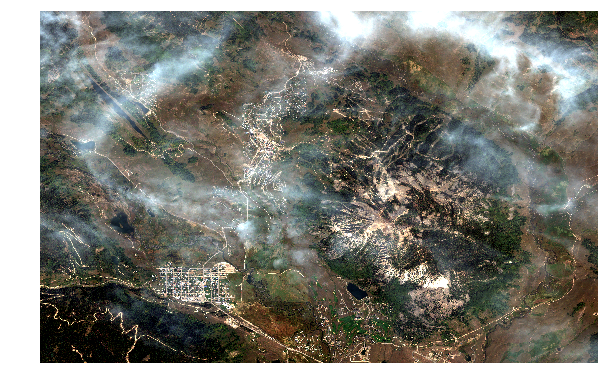

In [22]:
from gbdxtools.task import env
from gbdxtools import CatalogImage

image = CatalogImage('103001004965BE00', band_type="MS", bbox=bbox)

image.plot(w=10, h=10)

Now that you have an image, you can continue on to other tutorials to work with it.